In [5]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, Activation, Bidirectional, LSTM, SimpleRNN, Flatten
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [4]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os,random,math
TRAINING_DIR="/content/drive/MyDrive/propaganda_dataset_v2"

files=os.listdir(TRAINING_DIR)
traindf= pd.read_csv(os.path.join(TRAINING_DIR,files[0]),sep = '\t')
testdf= pd.read_csv(os.path.join(TRAINING_DIR,files[1]),sep = '\t')

In [8]:
traindf
bi_class_traindf = traindf.copy()
bi_class_testdf = testdf.copy()
bi_class_berttraindf = traindf.copy()
bi_class_berttestdf = traindf.copy()

In [9]:
def replace_token(sentences):
    start_sent = sentences.replace("<BOS>","")
    end_sent =start_sent.replace("<EOS>","")
    return end_sent

In [10]:
bi_class_traindf["tagged_in_context"]=bi_class_traindf["tagged_in_context"].map(replace_token)
bi_class_traindf["tagged_in_context"]=bi_class_traindf["tagged_in_context"].map(replace_token)

In [11]:
two_class_traindf=traindf
two_class_testdf=testdf

In [12]:
def convert_labels(label):
    return 1 if label=="not_propaganda" else 0
bi_class_traindf["label"]= bi_class_traindf["label"].map(convert_labels)
bi_class_testdf["label"]=two_class_testdf["label"].map(convert_labels)
bi_class_traindf

,label,tagged_in_context
0,1,"No, he will not be confirmed."
1,1,This declassification effort won’t make thing...
2,0,The Obama administration misled the American ...
3,1,“It looks like we’re capturing the demise of t...
4,1,"Location: Westerville, Ohio"
...,...,...
2409,1,We support and appreciate your business.”
2410,1,International Atomic Energy Agency (IAEA) Dire...
2411,1,What has been done: there has been work on for...
2412,1,This is the law of gradualness not the gradua...


In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    stops = stopwords.words('english')
    
    return sentence.lower()

In [15]:
bi_class_traindf["tagged_in_context"]=bi_class_traindf["tagged_in_context"].map(preprocess_text)
bi_class_testdf["tagged_in_context"]=bi_class_testdf["tagged_in_context"].map(preprocess_text)

In [16]:
from keras.utils import to_categorical
y_train = to_categorical(bi_class_traindf["label"])
y_test = to_categorical(bi_class_testdf["label"])

In [17]:
from keras.preprocessing.text import Tokenizer
no_words=10000
tokenizer=Tokenizer(num_words=no_words,lower=True)

In [18]:
mes = []
for i in bi_class_traindf['tagged_in_context']:
    mes.append(i.split())
for i in bi_class_testdf['tagged_in_context']:
    mes.append(i.split())

In [19]:
tokenizer.fit_on_texts(mes)

In [20]:
X_train=tokenizer.texts_to_sequences(bi_class_traindf["tagged_in_context"])  
X_train_pad=pad_sequences(X_train,maxlen=140,padding='post') 
X_test = tokenizer.texts_to_sequences(bi_class_testdf["tagged_in_context"])
X_test_pad = pad_sequences(X_test, maxlen = 140, padding = 'post')

In [21]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [22]:
vector_size = 100
gensim_weight_matrix = np.zeros((no_words ,vector_size))
gensim_weight_matrix.shape
words = list(glove_gensim.key_to_index.keys())
for word, index in tokenizer.word_index.items():
    if index < no_words: 
        if word in  words:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [23]:
EMBEDDING_DIM=100
class_no=2
modelrnn = Sequential()
modelrnn.add(Embedding(input_dim = no_words,output_dim = EMBEDDING_DIM,input_length= X_train_pad.shape[1],weights = [gensim_weight_matrix],trainable = False))
modelrnn.add(SimpleRNN(64,return_sequences= True))
modelrnn.add(Flatten())
modelrnn.add(Dense(class_no,activation='sigmoid'))

modelrnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 100)          1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 140, 64)           10560     
                                                                 
 flatten (Flatten)           (None, 8960)              0         
                                                                 
 dense (Dense)               (None, 2)                 17922     
                                                                 
Total params: 1,028,482
Trainable params: 28,482
Non-trainable params: 1,000,000
_________________________________________________________________


In [24]:
modelrnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = modelrnn.fit(X_train_pad,y_train, epochs=10,validation_data=(X_test_pad,y_test) )

Epoch 1/10
76/76 [==============================] - 17s 141ms/step - loss: 0.6522 - accuracy: 0.6263 - val_loss: 0.6581 - val_accuracy: 0.6569
Epoch 2/10
76/76 [==============================] - 11s 139ms/step - loss: 0.5392 - accuracy: 0.7411 - val_loss: 0.6098 - val_accuracy: 0.6914
Epoch 3/10
76/76 [==============================] - 9s 121ms/step - loss: 0.4745 - accuracy: 0.7763 - val_loss: 0.6190 - val_accuracy: 0.6828
Epoch 4/10
76/76 [==============================] - 10s 129ms/step - loss: 0.4263 - accuracy: 0.8032 - val_loss: 0.6865 - val_accuracy: 0.6241
Epoch 5/10
76/76 [==============================] - 11s 140ms/step - loss: 0.3882 - accuracy: 0.8347 - val_loss: 0.6303 - val_accuracy: 0.6776
Epoch 6/10
76/76 [==============================] - 11s 139ms/step - loss: 0.3461 - accuracy: 0.8633 - val_loss: 0.6709 - val_accuracy: 0.6483
Epoch 7/10
76/76 [==============================] - 9s 115ms/step - loss: 0.3026 - accuracy: 0.8819 - val_loss: 0.7001 - val_accuracy: 0.6621
E

In [25]:
loss, accuracy = modelrnn.evaluate(X_test_pad,y_test)
print(accuracy)

19/19 [==============================] - 0s 14ms/step - loss: 0.7955 - accuracy: 0.6621
0.6620689630508423


In [26]:
y_prediction = modelrnn.predict(X_test_pad)
y_prediction
threshold=0.5
binary_labels = np.where(y_prediction >= threshold, 1, 0)

19/19 [==============================] - 0s 13ms/step


In [28]:
y_prediction = modelrnn.predict(X_test_pad)
y_predict = np.argmax (y_prediction, axis = 1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_test, binary_labels))
print("Precision: ", precision_score(y_test, binary_labels, average='macro'))
print("Recall: ", recall_score(y_test, binary_labels, average='macro'))
print("F1 Score: ", f1_score(y_test, binary_labels, average='macro'))


19/19 [==============================] - 1s 35ms/step
Accuracy:  0.6482758620689655
Precision:  0.6654557542085144
Recall:  0.6666071279724692
F1 Score:  0.6649395509499136


In [29]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

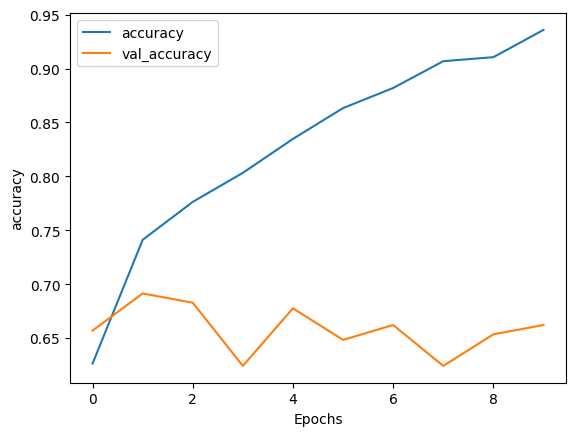

In [30]:
plot_graphs(history, "accuracy")

In [79]:
EMBEDDING_DIM = 100
class_num = 2
model = Sequential()
model.add(Embedding(input_dim = no_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))

model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dense(class_num, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "adam",metrics = "accuracy")

In [80]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 100)          1000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 140, 200)         160800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 140, 200)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 140, 400)         641600    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 140, 400)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 400)             

In [82]:
history_embeddings = model.fit(X_train_pad, y_train, 
                                epochs = 12, batch_size = 120, 
                                validation_data=(X_test_pad, y_test),
                                verbose = 1, callbacks= [es, mc]  )

Epoch 1/12
20/21 [===========================>..] - ETA: 0s - loss: 0.6499 - accuracy: 0.6042
Epoch 1: val_accuracy improved from -inf to 0.70172, saving model to ./model.h5
21/21 [==============================] - 16s 224ms/step - loss: 0.6493 - accuracy: 0.6048 - val_loss: 0.5950 - val_accuracy: 0.7017
Epoch 2/12
20/21 [===========================>..] - ETA: 0s - loss: 0.5857 - accuracy: 0.6979
Epoch 2: val_accuracy did not improve from 0.70172
21/21 [==============================] - 2s 112ms/step - loss: 0.5854 - accuracy: 0.6984 - val_loss: 0.6351 - val_accuracy: 0.6638
Epoch 3/12
20/21 [===========================>..] - ETA: 0s - loss: 0.5830 - accuracy: 0.7025
Epoch 3: val_accuracy improved from 0.70172 to 0.73276, saving model to ./model.h5
21/21 [==============================] - 3s 121ms/step - loss: 0.5823 - accuracy: 0.7034 - val_loss: 0.5596 - val_accuracy: 0.7328
Epoch 4/12
20/21 [===========================>..] - ETA: 0s - loss: 0.5336 - accuracy: 0.7446
Epoch 4: val_acc

In [83]:
loss, accuracy = model.evaluate(X_test_pad,y_test)
print(accuracy)

19/19 [==============================] - 1s 27ms/step - loss: 0.5622 - accuracy: 0.7500
0.75


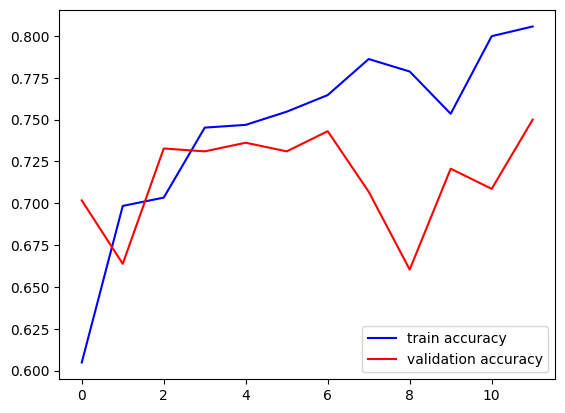

In [84]:
import matplotlib.pyplot as plt
plt.plot(history_embeddings.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embeddings.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')  
plt.show()

In [85]:
y_prediction = model.predict(X_test_pad)
y_prediction
threshold=0.5
binary_labels = np.where(y_prediction >= threshold, 1, 0)

19/19 [==============================] - 3s 26ms/step


In [86]:
y_prediction = model.predict(X_test_pad)
y_predict = np.argmax (y_prediction, axis = 1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_test, binary_labels))
print("Precision: ", precision_score(y_test, binary_labels, average='macro'))
print("Recall: ", recall_score(y_test, binary_labels, average='macro'))
print("F1 Score: ", f1_score(y_test, binary_labels, average='macro'))




19/19 [==============================] - 0s 23ms/step
Accuracy:  0.75
Precision:  0.7521818181818182
Recall:  0.7477405065552103
F1 Score:  0.7480519713959599


In [43]:
bi_class_berttraindf

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is <BOS> the law of gradualness not the g...


In [44]:
%pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [45]:
%pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [46]:
%pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
%pip install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
%pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
# Data processing
import pandas as pd
import numpy as np

import tensorflow as tf

# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate

In [52]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

In [53]:
def replace_token(sentences):
    start_sent = sentences.replace("<BOS>","")
    end_sent =start_sent.replace("<EOS>","")
    return end_sent


In [54]:
bi_class_berttraindf["tagged_in_context"]=bi_class_berttraindf["tagged_in_context"].map(replace_token)
bi_class_berttestdf["tagged_in_context"]=bi_class_berttestdf["tagged_in_context"].map(replace_token)
bi_class_berttraindf

,label,tagged_in_context
0,not_propaganda,"No, he will not be confirmed."
1,not_propaganda,This declassification effort won’t make thing...
2,flag_waving,The Obama administration misled the American ...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"Location: Westerville, Ohio"
...,...,...
2409,not_propaganda,We support and appreciate your business.”
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is the law of gradualness not the gradua...


In [55]:
two_class_berttraindf=bi_class_berttraindf
two_class_berttestdf=bi_class_berttestdf

two_class_berttestdf

,label,tagged_in_context
0,not_propaganda,"No, he will not be confirmed."
1,not_propaganda,This declassification effort won’t make thing...
2,flag_waving,The Obama administration misled the American ...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"Location: Westerville, Ohio"
...,...,...
2409,not_propaganda,We support and appreciate your business.”
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is the law of gradualness not the gradua...


In [56]:
def convert_labels(label):
    return 1 if label=="not_propaganda" else 0
two_class_berttestdf["label"]= two_class_berttestdf["label"].map(convert_labels)
two_class_berttraindf["label"]=two_class_berttraindf["label"].map(convert_labels)
two_class_berttraindf

,label,tagged_in_context
0,1,"No, he will not be confirmed."
1,1,This declassification effort won’t make thing...
2,0,The Obama administration misled the American ...
3,1,“It looks like we’re capturing the demise of t...
4,1,"Location: Westerville, Ohio"
...,...,...
2409,1,We support and appreciate your business.”
2410,1,International Atomic Energy Agency (IAEA) Dire...
2411,1,What has been done: there has been work on for...
2412,1,This is the law of gradualness not the gradua...


In [57]:
hg_train_data = Dataset.from_pandas(two_class_berttraindf)
hg_test_data = Dataset.from_pandas(two_class_berttestdf)

In [58]:
hg_train_data[4]

{'label': 1, 'tagged_in_context': ' Location: Westerville, Ohio  '}

In [59]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_data(data):
    return tokenizer(data["tagged_in_context"],
                     max_length=140,
                     truncation=True,
                     padding="max_length")
# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_data)
dataset_test = hg_test_data.map(tokenize_data)

Map:   0%|          | 0/2414 [00:00<?, ? examples/s]

Map:   0%|          | 0/2414 [00:00<?, ? examples/s]

In [60]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [61]:
training_args = TrainingArguments(
    output_dir="./sentiment_transfer_learning_transformer/",          
    logging_dir='./sentiment_transfer_learning_transformer/logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=5,              
    per_device_train_batch_size=1,  
    per_device_eval_batch_size=1,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [62]:
print(f'There are {len(evaluate.list_evaluation_modules())} evaluation models in Hugging Face.\n')

evaluate.list_evaluation_modules()

There are 158 evaluation models in Hugging Face.



['lvwerra/test',
 'precision',
 'code_eval',
 'roc_auc',
 'cuad',
 'xnli',
 'rouge',
 'pearsonr',
 'mse',
 'super_glue',
 'comet',
 'cer',
 'sacrebleu',
 'mahalanobis',
 'wer',
 'competition_math',
 'f1',
 'recall',
 'coval',
 'mauve',
 'xtreme_s',
 'bleurt',
 'ter',
 'accuracy',
 'exact_match',
 'indic_glue',
 'spearmanr',
 'mae',
 'squad',
 'chrf',
 'glue',
 'perplexity',
 'mean_iou',
 'squad_v2',
 'meteor',
 'bleu',
 'wiki_split',
 'sari',
 'frugalscore',
 'google_bleu',
 'bertscore',
 'matthews_correlation',
 'seqeval',
 'trec_eval',
 'rl_reliability',
 'jordyvl/ece',
 'angelina-wang/directional_bias_amplification',
 'cpllab/syntaxgym',
 'lvwerra/bary_score',
 'kaggle/amex',
 'kaggle/ai4code',
 'hack/test_metric',
 'yzha/ctc_eval',
 'codeparrot/apps_metric',
 'mfumanelli/geometric_mean',
 'daiyizheng/valid',
 'poseval',
 'erntkn/dice_coefficient',
 'mgfrantz/roc_auc_macro',
 'Vlasta/pr_auc',
 'gorkaartola/metric_for_tp_fp_samples',
 'idsedykh/metric',
 'idsedykh/codebleu2',
 'idsed

In [63]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [64]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.023800,0.769356,0.820215
2,0.847800,0.493520,0.902651
3,0.557600,0.299504,0.944490
4,0.370200,0.229141,0.960232
5,0.243100,0.183848,0.967688


TrainOutput(global_step=12070, training_loss=0.6085014185237806, metrics={'train_runtime': 1221.9728, 'train_samples_per_second': 9.877, 'train_steps_per_second': 9.877, 'total_flos': 868369260444000.0, 'train_loss': 0.6085014185237806, 'epoch': 5.0})

In [66]:
# Predictions
y_test_predict = trainer.predict(dataset_test)
y_test_logits = y_test_predict.predictions


In [67]:
y_test_probabilities = tf.nn.softmax(y_test_logits)
y_test_probabilities[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[1.5673049e-04, 9.9984324e-01],
       [9.9909925e-01, 9.0071349e-04],
       [9.9950898e-01, 4.9106311e-04],
       [2.1756226e-04, 9.9978250e-01],
       [1.4828658e-04, 9.9985170e-01]], dtype=float32)>

In [68]:
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)

In [69]:
y_test_actual_labels = y_test_predict.label_ids

In [70]:
y_test_actual_labels[:5]

array([1, 1, 0, 1, 1])

In [71]:
trainer.evaluate(dataset_test)

{'eval_loss': 0.18384838104248047,
 'eval_accuracy': 0.9676884838442419,
 'eval_runtime': 36.5249,
 'eval_samples_per_second': 66.092,
 'eval_steps_per_second': 66.092,
 'epoch': 5.0}

In [72]:
# Load f1 metric
metric_f1 = evaluate.load("f1")

# Compute f1 metric
metric_f1.compute(predictions=y_test_pred_labels, references=y_test_actual_labels)

{'f1': 0.9668367346938774}

In [73]:
# Load precision metric
metric_precision = evaluate.load("precision")

# Compute accuracy metric
metric_precision.compute(predictions=y_test_pred_labels, references=y_test_actual_labels)

{'precision': 0.979328165374677}

In [76]:
# Load recall metric
metric_recall = evaluate.load("recall")

# Compute recall metric
metric_recall.compute(predictions=y_test_pred_labels, references=y_test_actual_labels)

{'recall': 0.9546599496221663}

In [75]:
# Save tokenizer_to_our_system
tokenizer.save_pretrained('./sentiment_transfer_learning_transformer/')

# Save model to out system
trainer.save_model('./sentiment_transfer_learning_transformer/')